In [89]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
from datetime import datetime
from scipy.spatial import distance
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor, RandomForestRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVR, SVC
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")


In [45]:
eq_path = 'EQ 1965 to 2016.xlsx'
tectonic_Plates_path = 'Tectonic Plates Datasets.xlsx'

In [46]:
earthquake_data = pd.read_excel(eq_path)
tectonic_plate_data = pd.read_excel(tectonic_Plates_path)

In [47]:
# display informaton of earthquake data 
earthquake_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23412 entries, 0 to 23411
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   Date                        23412 non-null  datetime64[ns, UTC]
 1   Time                        23412 non-null  object             
 2   Latitude                    23412 non-null  float64            
 3   Longitude                   23412 non-null  float64            
 4   Type                        23412 non-null  object             
 5   Depth                       23412 non-null  float64            
 6   Depth Error                 4461 non-null   float64            
 7   Depth Seismic Stations      7097 non-null   float64            
 8   Magnitude                   23412 non-null  float64            
 9   Magnitude Type              23409 non-null  object             
 10  Magnitude Error             327 non-null    float64       

DATA PREPROCESSING

In [48]:
# dropping columns with missing values
if earthquake_data.isnull().values.any():
    # drop any columns with missing values
    eq_data = earthquake_data.dropna(axis=1)

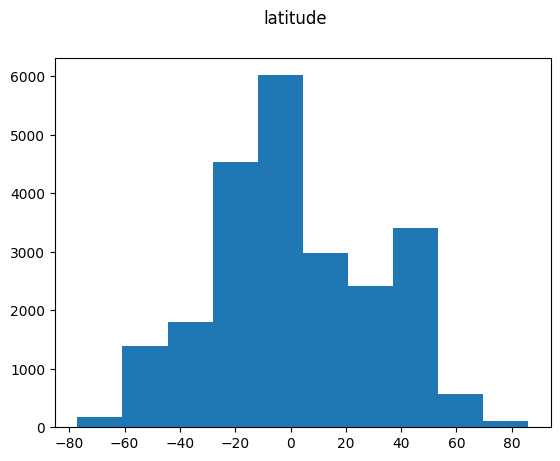

In [49]:
plt.hist(earthquake_data['Latitude'],bins=10)
plt.suptitle('latitude')
plt.show()

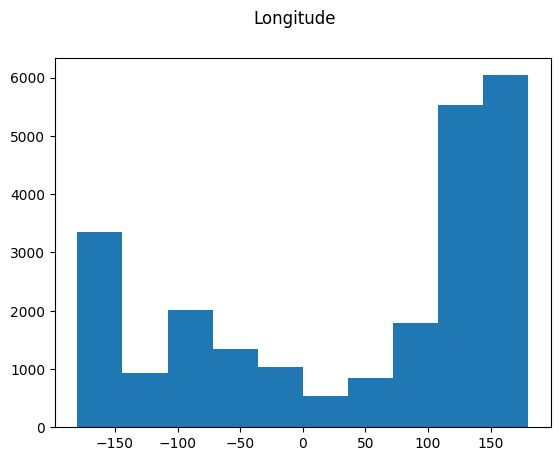

In [50]:
plt.hist(earthquake_data['Longitude'],bins=10)
plt.suptitle('Longitude')
plt.show()

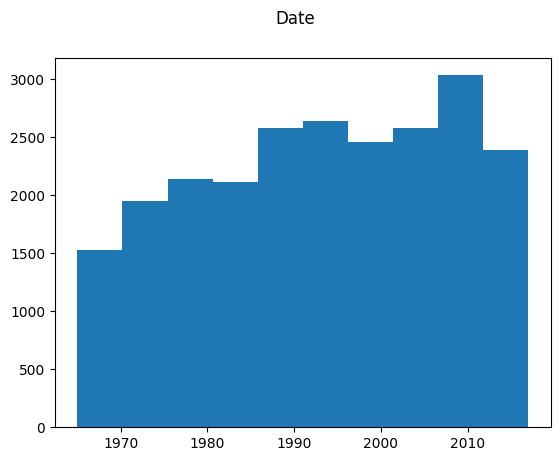

In [51]:
plt.hist(earthquake_data['Date'],bins=10)
plt.suptitle('Date')
plt.show()

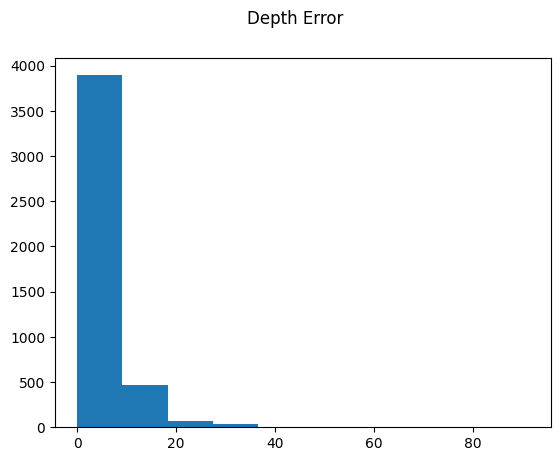

In [52]:
plt.hist(earthquake_data['Depth Error'],bins=10)
plt.suptitle('Depth Error')
plt.show()

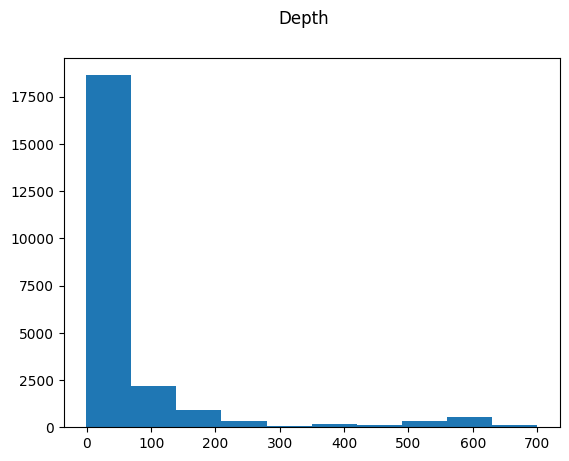

In [53]:
plt.hist(earthquake_data['Depth'],bins=10)
plt.suptitle('Depth')
plt.show()

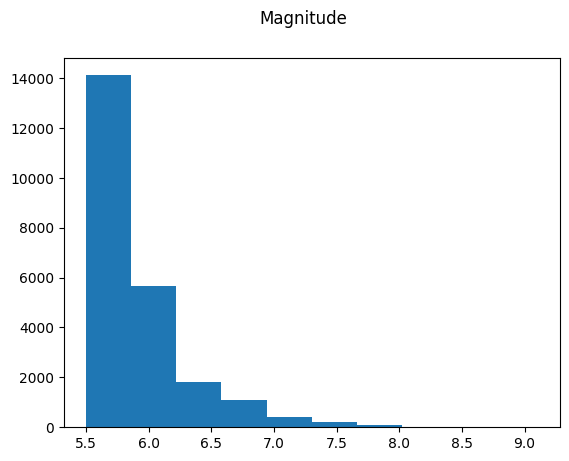

In [54]:
plt.hist(earthquake_data['Magnitude'],bins=10)
plt.suptitle('Magnitude')
plt.show()

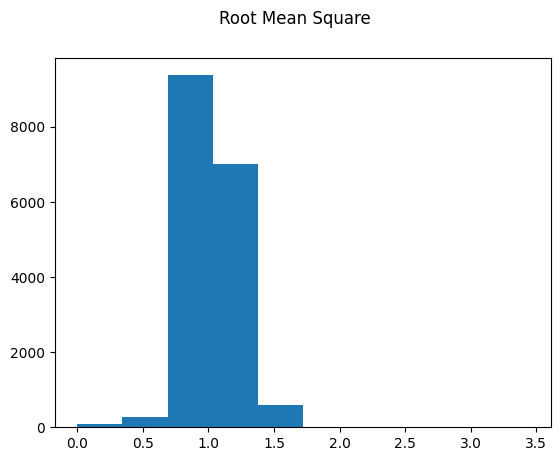

In [55]:
plt.hist(earthquake_data['Root Mean Square'],bins=10)
plt.suptitle('Root Mean Square')
plt.show()

In [56]:
# we add these 'Magnitude Type' because in this column have only three missing value 
# Group the data by 'Magnitude'
grouped = earthquake_data.groupby('Magnitude')

# Define a function to impute missing values in a series based on the most frequent value
def impute_most_frequent(series):
    most_frequent = series.mode().iloc[0]
    return series.fillna(most_frequent)

# Apply the imputation function to the 'Magnitude Type' column for each group
eq_data['Magnitude Type'] = grouped['Magnitude Type'].apply(impute_most_frequent)

In [57]:
# display first five records
eq_data.head()

,Date,Time,Latitude,Longitude,Type,Depth,Magnitude,ID,Source,Location Source,Magnitude Source,Status,Magnitude Type
0,1965-01-02 00:00:00+00:00,13:44:18,19.246,145.616,Earthquake,131.6,6.0,ISCGEM860706,ISCGEM,ISCGEM,ISCGEM,Automatic,MW
1,1965-01-04 00:00:00+00:00,11:29:49,1.863,127.352,Earthquake,80.0,5.8,ISCGEM860737,ISCGEM,ISCGEM,ISCGEM,Automatic,MW
2,1965-01-05 00:00:00+00:00,18:05:58,-20.579,-173.972,Earthquake,20.0,6.2,ISCGEM860762,ISCGEM,ISCGEM,ISCGEM,Automatic,MW
3,1965-01-08 00:00:00+00:00,18:49:43,-59.076,-23.557,Earthquake,15.0,5.8,ISCGEM860856,ISCGEM,ISCGEM,ISCGEM,Automatic,MW
4,1965-01-09 00:00:00+00:00,13:32:50,11.938,126.427,Earthquake,15.0,5.8,ISCGEM860890,ISCGEM,ISCGEM,ISCGEM,Automatic,MW


In [58]:
# check for incorrect dates
try:
    pd.to_datetime(eq_data['Date'])
    print("No incorrect dates found.")
except ValueError as e:
    print(f"Error: {e}")

No incorrect dates found.


In [59]:
#exploring the length of date objects
lengths = eq_data["Date"].astype(str).str.len()
lengths.value_counts()

25    23410
32        2
Name: Date, dtype: int64

In [60]:
#having a look at the fishy datapoints
incorrect_dates = np.where([lengths == 32])[1]
print("Fishy dates:", incorrect_dates)
eq_data.loc[incorrect_dates]

Fishy dates: [ 7512 20650]


,Date,Time,Latitude,Longitude,Type,Depth,Magnitude,ID,Source,Location Source,Magnitude Source,Status,Magnitude Type
7512,1985-04-28 02:53:41.530000+00:00,1985-04-28T02:53:41.530Z,-32.998,-71.766,Earthquake,33.0,5.6,USP0002E81,US,US,HRV,Reviewed,MW
20650,2011-03-13 02:23:34.520000+00:00,2011-03-13T02:23:34.520Z,36.344,142.344,Earthquake,10.1,5.8,USP000HWQP,US,US,GCMT,Reviewed,MWC


In [61]:
# Date 
eq_data['Year'] = eq_data['Date'].dt.year
eq_data['Month'] = eq_data['Date'].dt.month
eq_data['Day'] = eq_data['Date'].dt.day

In [62]:
#exploring the length of date objects
lengths = eq_data["Time"].astype(str).str.len()
lengths.value_counts()

8     23409
24        3
Name: Time, dtype: int64

In [63]:
#Having a look at the fishy datapoints
incorrect_time = np.where([lengths == 24])[1]
print("Fishy time:", incorrect_time)
eq_data.loc[incorrect_time]

Fishy time: [ 3378  7512 20650]


,Date,Time,Latitude,Longitude,Type,Depth,Magnitude,ID,Source,Location Source,Magnitude Source,Status,Magnitude Type,Year,Month,Day
3378,1975-02-23 02:58:41+00:00,1975-02-23T02:58:41.000Z,8.017,124.075,Earthquake,623.0,5.6,USP0000A09,US,US,US,Reviewed,MB,1975,2,23
7512,1985-04-28 02:53:41.530000+00:00,1985-04-28T02:53:41.530Z,-32.998,-71.766,Earthquake,33.0,5.6,USP0002E81,US,US,HRV,Reviewed,MW,1985,4,28
20650,2011-03-13 02:23:34.520000+00:00,2011-03-13T02:23:34.520Z,36.344,142.344,Earthquake,10.1,5.8,USP000HWQP,US,US,GCMT,Reviewed,MWC,2011,3,13


In [64]:
# Convert Time column to string type
eq_data['Time'] = eq_data['Time'].astype(str)

In [65]:
#fixing the wrong time and changing the datatype from numpy object to timedelta64[ns]
eq_data.loc[3378, "Time"] = "02:58:41"
eq_data.loc[7512, "Time"] = "02:53:41"
eq_data.loc[20650, "Time"] = "02:23:34"

In [66]:
# convert time delta 
eq_data['Time_']= pd.to_timedelta(eq_data['Time'])

In [67]:
# Convert the time column to datetime format
eq_data['Time'] = pd.to_datetime(eq_data['Time'])

In [68]:
# Extract the hour, minute, and second from the time column
eq_data['Hour'] = eq_data['Time'].dt.hour
eq_data['Minute'] = eq_data['Time'].dt.minute
eq_data['Second'] = eq_data['Time'].dt.second

In [69]:
# Create data and time column 
eq_data["Date_Time"]=eq_data["Date"] +eq_data["Time_"]

In [70]:
eq_data.corr()

,Latitude,Longitude,Depth,Magnitude,Year,Month,Day,Hour,Minute,Second
Latitude,1.000000,0.203546,-0.081020,0.034987,-0.076314,-0.005705,-0.001801,-0.010046,-0.004641,-0.002856
Longitude,0.203546,1.000000,-0.085861,0.038579,-0.037452,-0.008712,-0.009971,-0.014356,0.006549,-0.001586
Depth,-0.081020,-0.085861,1.000000,0.023457,-0.024004,0.001784,0.008428,0.010307,-0.001555,-0.012616
Magnitude,0.034987,0.038579,0.023457,1.000000,-0.032015,0.001175,-0.002099,0.004514,0.002777,-0.007209
Year,-0.076314,-0.037452,-0.024004,-0.032015,1.000000,-0.004657,-0.012096,0.001812,-0.008153,-0.009691
Month,-0.005705,-0.008712,0.001784,0.001175,-0.004657,1.000000,0.019878,0.005483,0.003273,0.011444
Day,-0.001801,-0.009971,0.008428,-0.002099,-0.012096,0.019878,1.000000,0.011516,-0.010994,0.005011
Hour,-0.010046,-0.014356,0.010307,0.004514,0.001812,0.005483,0.011516,1.000000,-0.000806,0.006118
Minute,-0.004641,0.006549,-0.001555,0.002777,-0.008153,0.003273,-0.010994,-0.000806,1.000000,0.011532
Second,-0.002856,-0.001586,-0.012616,-0.007209,-0.009691,0.011444,0.005011,0.006118,0.011532,1.000000


LABEL ENCODING

In [71]:
from sklearn.preprocessing import LabelEncoder

# define LabelEncoder object
le = LabelEncoder()

# encode categorical columns to numerical
eq_data['Type'] = le.fit_transform(eq_data['Type'])
eq_data['Source'] = le.fit_transform(eq_data['Source'])
eq_data['Location Source'] = le.fit_transform(eq_data['Location Source'])
eq_data['Status'] = le.fit_transform(eq_data['Status'])
eq_data['Magnitude Type'] = le.fit_transform(eq_data['Status'])

In [72]:
# convert integer value to string 
eq_data['Magnitude Source'] = eq_data['Magnitude Source'].astype(str)

In [73]:
# label encoder 
eq_data['Magnitude Source'] = le.fit_transform(eq_data['Magnitude Source'])

Merge Dataset

In [74]:
from scipy.spatial import KDTree

# assume eq_data1 and eq_data2 are the two earthquake datasets
tree = KDTree(tectonic_plate_data[['lat', 'lon']])

# find the index of the closest point in eq_data2 for each point in eq_data1
distances, indices = tree.query(eq_data[['Latitude', 'Longitude']], k=1)

# merge the two datasets based on the indices
combine_data = pd.concat([eq_data.reset_index(drop=True), tectonic_plate_data.loc[indices].reset_index(drop=True)], axis=1)

Label encoding

In [75]:
# encode categorical columns to numerical
combine_data['plate'] = le.fit_transform(combine_data['plate'])

In [76]:
combine_data.corr()

,Latitude,Longitude,Type,Depth,Magnitude,Source,Location Source,Magnitude Source,Status,Magnitude Type,Year,Month,Day,Hour,Minute,Second,plate,lat,lon
Latitude,1.000000,0.203546,0.109949,-0.081020,0.034987,-0.122796,-0.151290,0.002269,-0.101484,-0.101484,-0.076314,-0.005705,-0.001801,-0.010046,-0.004641,-0.002856,0.065978,0.997669,0.204143
Longitude,0.203546,1.000000,-0.008938,-0.085861,0.038579,-0.015574,0.023289,0.047328,-0.041249,-0.041249,-0.037452,-0.008712,-0.009971,-0.014356,0.006549,-0.001586,-0.110330,0.203280,0.999909
Type,0.109949,-0.008938,1.000000,-0.050394,-0.005996,0.008619,0.011235,0.081102,0.031264,0.031264,-0.066539,0.029017,0.017901,-0.056542,0.032624,0.043688,0.028160,0.089598,-0.008885
Depth,-0.081020,-0.085861,-0.050394,1.000000,0.023457,0.012838,0.022434,-0.013492,0.003848,0.003848,-0.024004,0.001784,0.008428,0.010307,-0.001555,-0.012616,-0.108037,-0.077893,-0.084959
Magnitude,0.034987,0.038579,-0.005996,0.023457,1.000000,-0.105781,-0.092072,-0.009185,-0.103700,-0.103700,-0.032015,0.001175,-0.002099,0.004514,0.002777,-0.007209,-0.018013,0.035106,0.038354
Source,-0.122796,-0.015574,0.008619,0.012838,-0.105781,1.000000,0.928376,0.270476,0.966317,0.966317,0.559162,0.006819,-0.003016,-0.001678,0.007194,0.003439,-0.017577,-0.124082,-0.015643
Location Source,-0.151290,0.023289,0.011235,0.022434,-0.092072,0.928376,1.000000,0.255677,0.896696,0.896696,0.504635,0.005984,-0.005377,-0.002655,0.008076,0.004697,-0.027492,-0.154153,0.023170
Magnitude Source,0.002269,0.047328,0.081102,-0.013492,-0.009185,0.270476,0.255677,1.000000,0.253269,0.253269,0.092590,-0.001858,0.001941,0.003146,0.000914,0.006434,0.005642,-0.000035,0.047328
Status,-0.101484,-0.041249,0.031264,0.003848,-0.103700,0.966317,0.896696,0.253269,1.000000,1.000000,0.575886,0.006861,0.002406,0.003778,0.007249,0.001510,-0.005949,-0.103276,-0.041371
Magnitude Type,-0.101484,-0.041249,0.031264,0.003848,-0.103700,0.966317,0.896696,0.253269,1.000000,1.000000,0.575886,0.006861,0.002406,0.003778,0.007249,0.001510,-0.005949,-0.103276,-0.041371


Creating a column "Has Aftershock" based on the information of earthquake magnitude, time and distance windows.

In [77]:
from scipy.spatial.distance import cdist

# Set threshold and time/distance windows
magnitude_threshold = 4.0
time_window = pd.Timedelta(days=3)
distance_window = 100  # in kilometers

# Calculate pairwise distances between earthquakes
distances = cdist(combine_data[['Latitude', 'Longitude']], combine_data[['lat', 'lon']])

# Find the indices of earthquakes that have an aftershock within the time and distance windows
has_aftershock = np.zeros(len(combine_data), dtype=bool)
for i in range(len(combine_data)):
    aftershocks = np.where((distances[i] <= distance_window) & 
                           (combine_data['Magnitude'] > magnitude_threshold) & 
                           (combine_data['Date_Time'] > combine_data.loc[i, 'Date_Time']) & 
                           (combine_data['Date_Time'] <= combine_data.loc[i, 'Date_Time'] + time_window))[0]
    if len(aftershocks) > 0:
        has_aftershock[i] = True
        
# Add a column to the dataframe indicating whether each earthquake has an aftershock or not
combine_data['Has Aftershock'] = has_aftershock.astype(int)

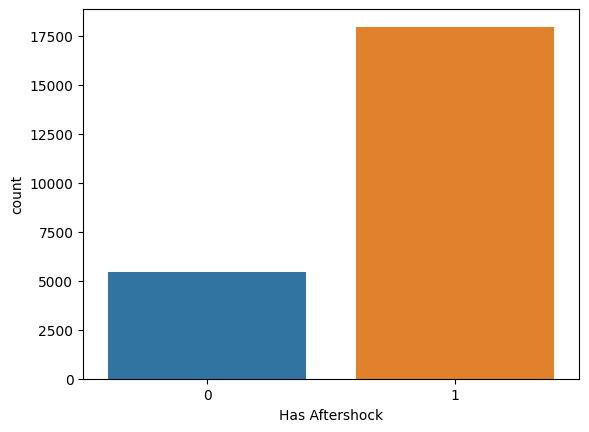

In [78]:
# Create a count plot
sns.countplot(x=combine_data['Has Aftershock'])

# Show the plot
plt.show()

In [79]:
X = combine_data.drop(['Date','Time','ID',"Time_","Date_Time"], axis=1)
y = combine_data['Has Aftershock']

In [80]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [81]:
# Logistic Regression model
logreg_model = LogisticRegression()
logreg_model.fit(X_train, y_train)
y_pred_logreg = logreg_model.predict(X_test)
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)

# Random Forest model
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)

# Decision Tree model
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)
accuracy_dt = accuracy_score(y_test, y_pred_dt)

# Naive Bayes model
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
y_pred_nb = nb_model.predict(X_test)
accuracy_nb = accuracy_score(y_test, y_pred_nb)

# KNN model
knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)
accuracy_knn = accuracy_score(y_test, y_pred_knn)

In [82]:
# Compare the accuracies of all models
print("Logistic Regression Accuracy:", accuracy_logreg)
print("Random Forest Accuracy:", accuracy_rf)
print("Decision Tree Accuracy:", accuracy_dt)
print("Naive Bayes Accuracy:", accuracy_nb)
print("KNN Accuracy:", accuracy_knn)

Logistic Regression Accuracy: 0.7979927396967755
Random Forest Accuracy: 1.0
Decision Tree Accuracy: 1.0
Naive Bayes Accuracy: 1.0
KNN Accuracy: 0.7467435404655136


LSTM

In [83]:
# MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [84]:
# Reshape the data for LSTM
# Reshape the feature data to be 3-dimensional
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))


In [85]:
# Initialize an LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(64, input_shape=(1, X_train.shape[2]), activation='relu', return_sequences=True))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(32, activation='relu'))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1, activation='sigmoid'))

# Compile the model
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit the model to the training data
history = lstm_model.fit(X_train, y_train,  validation_split=0.2, epochs=5, batch_size=32)

# Predict on the test data
y_pred_prob = lstm_model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)

Epoch 1/5
469/469 [==============================] - 7s 5ms/step - loss: 0.1442 - accuracy: 0.9404 - val_loss: 7.4925e-04 - val_accuracy: 1.0000
Epoch 2/5
469/469 [==============================] - 2s 4ms/step - loss: 7.8527e-04 - accuracy: 1.0000 - val_loss: 7.9177e-05 - val_accuracy: 1.0000
Epoch 3/5
469/469 [==============================] - 2s 4ms/step - loss: 3.4662e-04 - accuracy: 0.9999 - val_loss: 1.7895e-04 - val_accuracy: 1.0000
Epoch 4/5
469/469 [==============================] - 2s 4ms/step - loss: 1.1803e-04 - accuracy: 1.0000 - val_loss: 1.9305e-05 - val_accuracy: 1.0000
Epoch 5/5
147/147 [==============================] - 1s 2ms/step


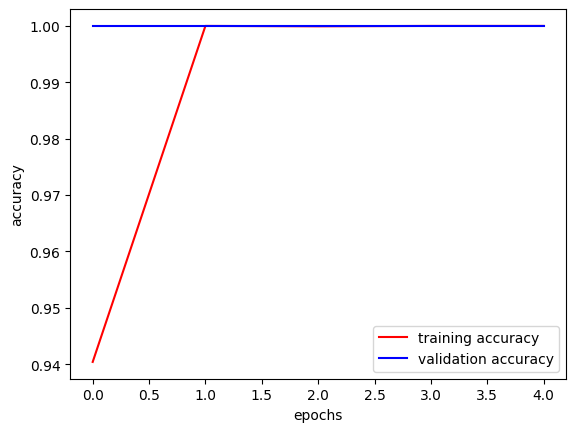

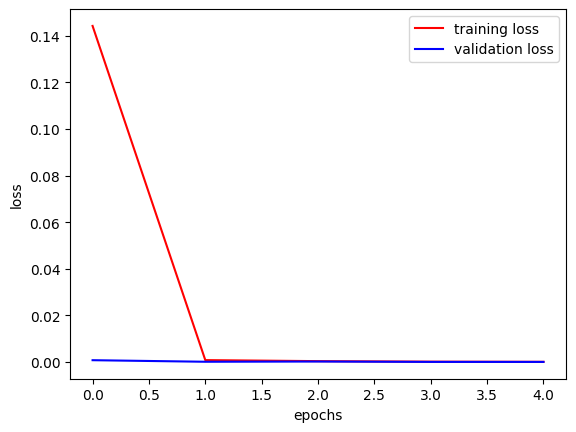

In [86]:
import matplotlib.pyplot as plt
# Plot graph
plt.plot(history.history['accuracy'],'r',label='training accuracy')
plt.plot(history.history['val_accuracy'],'b',label='validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.show()
plt.plot(history.history['loss'],'r',label='training loss')
plt.plot(history.history['val_loss'],'b',label='validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [93]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Assuming you already have the ground truth labels (y_test) and predicted labels (y_pred) for each model
# For example: y_pred_logreg, y_pred_rf, y_pred_dt, y_pred_nb, y_pred_knn, y_pred_lstm

models = {
    'Logistic Regression': y_pred_logreg,
    'Random Forest': y_pred_rf,
    'Decision Tree': y_pred_dt,
    'Naive Bayes': y_pred_nb,
    'KNN': y_pred_knn,
    'LSTM': y_pred
}

for name, y_pred in models.items():
    print(f"--- {name} ---")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1-score:", f1_score(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print()




--- Logistic Regression ---
Accuracy: 0.7979927396967755
Precision: 0.8155550204671322
Recall: 0.9495374264087468
F1-score: 0.8774611398963731
Confusion Matrix:
 [[ 350  766]
 [ 180 3387]]

--- Random Forest ---
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0
Confusion Matrix:
 [[1116    0]
 [   0 3567]]

--- Decision Tree ---
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0
Confusion Matrix:
 [[1116    0]
 [   0 3567]]

--- Naive Bayes ---
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0
Confusion Matrix:
 [[1116    0]
 [   0 3567]]

--- KNN ---
Accuracy: 0.7467435404655136
Precision: 0.7921472392638037
Recall: 0.9049621530698065
F1-score: 0.8448050248626013
Confusion Matrix:
 [[ 269  847]
 [ 339 3228]]

--- LSTM ---
Accuracy: 0.23830877642536835
Precision: 0.0
Recall: 0.0
F1-score: 0.0
Confusion Matrix:
 [[1116    0]
 [3567    0]]



In [ ]:
K-Fold Cross validation

In [95]:
from sklearn.model_selection import cross_val_score

# Set the number of folds
k = 5

# Logistic Regression
logreg_cv_scores = cross_val_score(LogisticRegression(), X, y, cv=k)
logreg_cv_mean = logreg_cv_scores.mean()

# Random Forest
rf_cv_scores = cross_val_score(RandomForestClassifier(), X, y, cv=k)
rf_cv_mean = rf_cv_scores.mean()

# Decision Tree
dt_cv_scores = cross_val_score(DecisionTreeClassifier(), X, y, cv=k)
dt_cv_mean = dt_cv_scores.mean()

# Naive Bayes
nb_cv_scores = cross_val_score(GaussianNB(), X, y, cv=k)
nb_cv_mean = nb_cv_scores.mean()

# KNN
knn_cv_scores = cross_val_score(KNeighborsClassifier(), X, y, cv=k)
knn_cv_mean = knn_cv_scores.mean()

# Print the cross-validation scores for each model
print("Logistic Regression CV Mean:", logreg_cv_mean)
print("Random Forest CV Mean:", rf_cv_mean)
print("Decision Tree CV Mean:", dt_cv_mean)
print("Naive Bayes CV Mean:", nb_cv_mean)
print("KNN CV Mean:", knn_cv_mean)

Logistic Regression CV Mean: 0.7833558775444789
Random Forest CV Mean: 1.0
Decision Tree CV Mean: 1.0
Naive Bayes CV Mean: 1.0
KNN CV Mean: 0.7354366722026091
